# Clustering

This notebook focuses on clustering. For this project, we applied a $k$-medians clustering on the reduced dimensionality.

*Note: This notebook takes a long time to run. We've exported the results of our clustering and validation results for convenience.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from IPython.display import HTML
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from pyclustering.cluster.kmedians import kmedians
from pyclustering.utils.metric import distance_metric, type_metric

%matplotlib inline

In [2]:
def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    return np.sum([(dist(x, centroids[y_])**2 / (2 * np.sum(y == y_)))
                   for x, y_ in zip(X, y)])


def gap_statistic_kmedians(X, y, centroids, b):
    """Compute the gap statistic for a k-medians clusterer
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(1337)
    gap_vec = []
    
    w_k = pooled_within_ssd(X, y, centroids, cityblock)
    
    for i in range(b):
        x_hat = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0),
                                  size=(X.shape))
        kmd = kmedians(x_hat, x_hat[:len(centroids), :], ccore=False,
                       metric=distance_metric(type_metric.MANHATTAN))
        kmd = kmd.process()
        y_hat = kmd.predict(x_hat)
        w_ki = pooled_within_ssd(x_hat, y_hat, np.array(kmd.get_medians()),
                                 cityblock)
        gap_vec.append(np.log(w_ki) - np.log(w_k))
    return np.mean(gap_vec), np.std(gap_vec)


def cluster_range_kmedians(X, k_start, k_stop, actual=None):
    """Apply KMedians with increasing k. Get clusters and validation values"""
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedians(X, X[:k,:], ccore=False,
                               metric=distance_metric(type_metric.MANHATTAN))
        clusterer_k.process()
        clusters = clusterer_k.get_clusters()
        
        y = np.zeros(len(X)).astype(int)
        for cluster, point in enumerate(clusters):
            y[point] = cluster
        
        ys.append(y)
        chs.append(calinski_harabasz_score(X, y))
#         scs.append(silhouette_score(X, y))
        
        inertia = clusterer_k.get_total_wce()
        inertias.append(inertia)
        
#         gs = gap_statistic_kmedians(X, y, clusterer_k.get_medians(), 5)
#         gss.append(gs[0])
#         gssds.append(gs[1])
        
    return {
        'ys': ys, 'inertias': inertias, 'chs': chs, 'gss': gss, 'gssds': gssds
    }

def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

## Running the Clustering

This notebook takes in `pca.npy` from the dimensionality reduction notebook.

In [3]:
data = np.load('pca.npy')

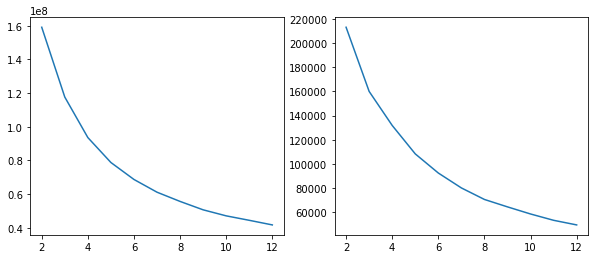

In [4]:
kmd_crange_svd = cluster_range_kmedians(data, 2, 12)
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.lineplot(x=range(2, 2 + len(kmd_crange_svd['inertias'])),
             y=(kmd_crange_svd['inertias']), ax=ax[0])
sns.lineplot(x=range(2, 2 + len(kmd_crange_svd['chs'])),
             y=(kmd_crange_svd['chs']), ax=ax[1])

In [8]:
df = pd.DataFrame({'ys': kmd_crange_svd['ys'],
                   'inertias': kmd_crange_svd['inertias'],
                   'chs': kmd_crange_svd['chs']},
                  index=range(2,13))

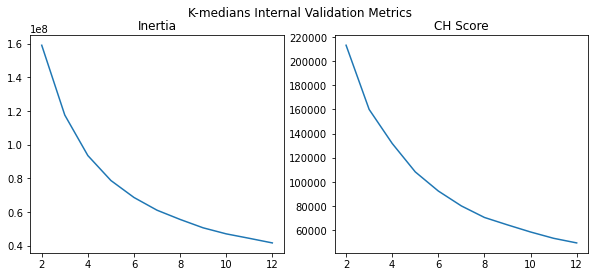

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
df.inertias.plot(ax=ax[0])
ax[0].set_title('Inertia')
df.chs.plot(ax=ax[1])
ax[1].set_title('CH Score')
plt.suptitle('K-medians Internal Validation Metrics');

In [13]:
df2 = pd.DataFrame(np.array(kmd_crange_svd['ys']).T,
                   columns=range(2,13))
df2.to_csv('cluster_labels.csv.gz', index=False)

In [15]:
df.iloc[:, 1:].to_csv('validation.csv.gz')